# Kobe Bryant helicopter: Flight path data

### Load Python tools

In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
import glob
import io
import os
from shapely.geometry import Point, LineString
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

### Get all the flight data from flightradar24's directory.

In [4]:
# urls = \
#     ['https://secure.flightradar24.com/N72EX/2018_10/',
#     'https://secure.flightradar24.com/N72EX/2018_11/',
#     'https://secure.flightradar24.com/N72EX/2018_12/',
#     'https://secure.flightradar24.com/N72EX/2019_01/',
#     'https://secure.flightradar24.com/N72EX/2019_02/',
#     'https://secure.flightradar24.com/N72EX/2019_03/',
#     'https://secure.flightradar24.com/N72EX/2019_04/',
#     'https://secure.flightradar24.com/N72EX/2019_05/',
#     'https://secure.flightradar24.com/N72EX/2019_06/',
#     'https://secure.flightradar24.com/N72EX/2019_07/',
#     'https://secure.flightradar24.com/N72EX/2019_08/',
#     'https://secure.flightradar24.com/N72EX/2019_09/',
#     'https://secure.flightradar24.com/N72EX/2019_10/',
#     'https://secure.flightradar24.com/N72EX/2019_11/',
#     'https://secure.flightradar24.com/N72EX/2019_12/',
#     'https://secure.flightradar24.com/N72EX/2020_01/']

In [19]:
# !cd input
# !unzip \*.zip
# !rm -f *.zip

### What does a flight file look like? 

In [23]:
a_flight = pd.read_csv('input/paths/20200126_598114379.csv')
a_flight.head(10)

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk
0,1579998328,375,301,33.66856,-117.87932,9795,74,0
1,1579998340,575,300,33.67126,-117.88470,9795,91,0
2,1579998352,700,295,33.67387,-117.89081,9795,115,0
3,1579998362,800,301,33.67653,-117.89687,9795,126,0
4,1579998371,850,301,33.67950,-117.90269,9795,132,4300
5,1579998378,900,300,33.68156,-117.90678,9795,134,4300
6,1579998387,950,300,33.68455,-117.91283,9795,136,4300
7,1579998398,1075,300,33.68807,-117.91996,9795,137,4300
8,1579998408,1175,300,33.69122,-117.92635,9795,136,4300
9,1579998422,1225,300,33.69586,-117.93560,9795,139,4300


In [24]:
a_flight.dtypes

snapshot_id      int64
altitude         int64
heading          int64
latitude       float64
longitude      float64
radar_id         int64
speed            int64
squawk           int64
dtype: object

### Concatenate the flight path files

In [25]:
#set path
path = 'input/paths/'

In [26]:
files = glob.glob(os.path.join(path, "*.csv"))

### Read the csv and create a 'flightid' field so we can track unique flights

In [36]:
file_df = (pd.read_csv(f, encoding = "ISO-8859-1", low_memory=False)\
           .assign(flightid=os.path.basename(f)) for f in files)

In [ ]:
concatenated_df = pd.concat(file_df, ignore_index=True)

In [41]:
concatenated_df['flightid'] = concatenated_df['flightid']\
    .str.replace('DL89_','')\
    .str.replace('.csv','')

### How many flight segments do we have? 

In [ ]:
len(concatenated_df)

In [45]:
concatenated_df.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid
0,1558727880,0,271,33.66540,-117.87410,4062,0,0,20190524_547520609
1,1558728111,0,230,33.66537,-117.87434,4062,33,4300,20190524_547520609
2,1558728117,50,178,33.66486,-117.87449,4062,31,4300,20190524_547520609
3,1558728126,275,187,33.66316,-117.87456,4062,46,4300,20190524_547520609
4,1558728132,400,264,33.66179,-117.87674,4062,75,4300,20190524_547520609


### Clean up the dataframe

In [43]:
concatenated_df.columns = concatenated_df.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [46]:
flights = pd.DataFrame(concatenated_df.sort_values(by='snapshot_id', ascending=False))
flights.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid
68898,1579998831,0,271,33.81313,-118.16036,2958,49,4300,20200126_598114379
68897,1579998823,50,271,33.81289,-118.15881,2958,49,4300,20200126_598114379
68896,1579998816,75,272,33.81285,-118.15672,2958,53,4300,20200126_598114379
68895,1579998807,100,267,33.81285,-118.15401,2958,60,4300,20200126_598114379
68894,1579998800,125,270,33.81294,-118.15163,2958,62,4300,20200126_598114379


### Split location field into lat, lon to create a geodataframe

In [48]:
# lat = []
# lon = []

# for row in flights['position']:
#     lat.append(row.split(',')[0])
#     lon.append(row.split(',')[1])
        
# flights['latitude'] = lat
# flights['longitude'] = lon

In [49]:
flights['latitude'] = flights['latitude'].astype(float)
flights['longitude'] = flights['longitude'].astype(float)

### Convert the UTC date string into an actual datetime series

In [ ]:
flights['date_time'] = pd.to_datetime(flights['snapshot_id'],unit='s')

In [52]:
flights['utc_datetime'] = pd.to_datetime(flights['date_time'], format='%Y-%m-%dT%H:%M:%SZ').dt.tz_localize('UTC')

### Localize to Los Angeles time

In [53]:
flights['datetime_pst'] = flights['utc_datetime'].dt.tz_convert('America/Los_Angeles')

In [54]:
flights.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid,date_time,utc_datetime,datetime_pst
68898,1579998831,0,271,33.81313,-118.16036,2958,49,4300,20200126_598114379,2020-01-26 00:33:51,2020-01-26 00:33:51+00:00,2020-01-25 16:33:51-08:00
68897,1579998823,50,271,33.81289,-118.15881,2958,49,4300,20200126_598114379,2020-01-26 00:33:43,2020-01-26 00:33:43+00:00,2020-01-25 16:33:43-08:00
68896,1579998816,75,272,33.81285,-118.15672,2958,53,4300,20200126_598114379,2020-01-26 00:33:36,2020-01-26 00:33:36+00:00,2020-01-25 16:33:36-08:00
68895,1579998807,100,267,33.81285,-118.15401,2958,60,4300,20200126_598114379,2020-01-26 00:33:27,2020-01-26 00:33:27+00:00,2020-01-25 16:33:27-08:00
68894,1579998800,125,270,33.81294,-118.15163,2958,62,4300,20200126_598114379,2020-01-26 00:33:20,2020-01-26 00:33:20+00:00,2020-01-25 16:33:20-08:00


### In case we need simplier date/time fields

In [56]:
flights['date'] = pd.to_datetime(flights['datetime_pst']).dt.strftime('%m/%d/%Y')
flights['time'] = pd.to_datetime(flights['datetime_pst']).dt.strftime('%H:%M:%S')
flights['display_time'] = pd.to_datetime(flights['datetime_pst']).dt.strftime('%I:%M %p')
flights['weekday'] = flights['datetime_pst'].dt.weekday_name

### Lighten the dataframe a bit

In [17]:
# flights = flights.drop(['utc', 'timestamp','position','utc_datetime'], axis=1)

In [57]:
flights.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid,date_time,utc_datetime,datetime_pst,date,time,display_time,weekday
68898,1579998831,0,271,33.81313,-118.16036,2958,49,4300,20200126_598114379,2020-01-26 00:33:51,2020-01-26 00:33:51+00:00,2020-01-25 16:33:51-08:00,01/25/2020,16:33:51,04:33 PM,Saturday
68897,1579998823,50,271,33.81289,-118.15881,2958,49,4300,20200126_598114379,2020-01-26 00:33:43,2020-01-26 00:33:43+00:00,2020-01-25 16:33:43-08:00,01/25/2020,16:33:43,04:33 PM,Saturday
68896,1579998816,75,272,33.81285,-118.15672,2958,53,4300,20200126_598114379,2020-01-26 00:33:36,2020-01-26 00:33:36+00:00,2020-01-25 16:33:36-08:00,01/25/2020,16:33:36,04:33 PM,Saturday
68895,1579998807,100,267,33.81285,-118.15401,2958,60,4300,20200126_598114379,2020-01-26 00:33:27,2020-01-26 00:33:27+00:00,2020-01-25 16:33:27-08:00,01/25/2020,16:33:27,04:33 PM,Saturday
68894,1579998800,125,270,33.81294,-118.15163,2958,62,4300,20200126_598114379,2020-01-26 00:33:20,2020-01-26 00:33:20+00:00,2020-01-25 16:33:20-08:00,01/25/2020,16:33:20,04:33 PM,Saturday


### Export the dataframe as a CSV

In [58]:
flights.to_csv('output/all_flights.csv')

---

## Geography

### Let's convert our flights data to a geodataframe

In [59]:
flights_geo = gpd.GeoDataFrame(flights, geometry=gpd.points_from_xy(flights['longitude'], flights['latitude']))

In [69]:
flights_geo.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid,date_time,utc_datetime,datetime_pst,date,time,display_time,weekday,geometry
68898,1579998831,0,271,33.81313,-118.16036,2958,49,4300,20200126_598114379,2020-01-26 00:33:51,2020-01-26 00:33:51+00:00,2020-01-25 16:33:51-08:00,01/25/2020,16:33:51,04:33 PM,Saturday,POINT (-118.16036 33.81313)
68897,1579998823,50,271,33.81289,-118.15881,2958,49,4300,20200126_598114379,2020-01-26 00:33:43,2020-01-26 00:33:43+00:00,2020-01-25 16:33:43-08:00,01/25/2020,16:33:43,04:33 PM,Saturday,POINT (-118.15881 33.81289)
68896,1579998816,75,272,33.81285,-118.15672,2958,53,4300,20200126_598114379,2020-01-26 00:33:36,2020-01-26 00:33:36+00:00,2020-01-25 16:33:36-08:00,01/25/2020,16:33:36,04:33 PM,Saturday,POINT (-118.15672 33.81285)
68895,1579998807,100,267,33.81285,-118.15401,2958,60,4300,20200126_598114379,2020-01-26 00:33:27,2020-01-26 00:33:27+00:00,2020-01-25 16:33:27-08:00,01/25/2020,16:33:27,04:33 PM,Saturday,POINT (-118.15401 33.81285)
68894,1579998800,125,270,33.81294,-118.15163,2958,62,4300,20200126_598114379,2020-01-26 00:33:20,2020-01-26 00:33:20+00:00,2020-01-25 16:33:20-08:00,01/25/2020,16:33:20,04:33 PM,Saturday,POINT (-118.15163 33.81294)


### We need flight paths. Convert to points to linestring

In [ ]:
flights_geo_line = flights_geo.groupby('flightid')['geometry']\
    .apply(lambda x: LineString(x.tolist()) if x.size > 1 else x.tolist())

In [1]:
import re 
re.sub("\s+", ",", flights_geo['geometry'].strip())

NameError: name 'flights_geo' is not defined

In [ ]:
flights_geo_line = flights_geo_line.groupby(['ID', 'Hour'])['geometry'].apply(lambda x:                 LineString(x.tolist()))
    geo_df2 = gpd.GeoDataFrame(geo_df2, geometry='geometry')

In [77]:
flights_geo_lines = gpd.GeoDataFrame(flights_geo_line, geometry='geometry').reset_index()

TypeError: Input geometry column must contain valid geometry objects.

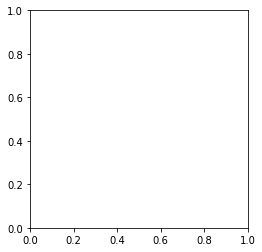

In [76]:
flights_geo_lines.plot()

### Remove anomalous flights

In [30]:
flights_geo_line = flights_geo_line.drop([31, 231])

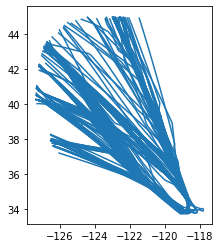

In [31]:
flights_geo_line.plot()

In [32]:
flights_geo.to_file('output/flights_geo.geojson', driver='GeoJSON')

In [33]:
flights_geo_line.to_file('output/flights_geo_line.geojson', driver='GeoJSON')

In [35]:
flights_geo_delta = flights_geo_line[flights_geo['flightid'] == '23856f50']

//anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:471: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [ ]:
flights_geo_line_delta = flights_geo_line_cali[flights_geo_line['flightid'] == '23856f50']

In [ ]:
flights_geo_line_delta.to_file('output/flights_geo_line_delta.geojson', driver='GeoJSON')

In [ ]:
flights_geo_line_delta.plot()

In [ ]:
flights_geo_delta.to_file('output/flights_geo_delta.geojson', driver='GeoJSON')

In [ ]:
delta_89_gas_flight.to_csv('output/delta_89_gas_flight.csv')

In [ ]:
delta_89_gas_flight.to_file('output/delta_89_gas_flight.geojson', driver='GeoJSON')